# State evolution for experimental testing of SPA - no shield
Performing state evolution for molecules coming out of State Preparation Region A *after* the state preparation has been done. Thus interested primarily in the evolution of the J = 2, mJ = 0 states as the electric field is ramped down in the absence of microwaves. In this notebook I'm illustrating what happens if there is no electric field shield.

## Import packages

In [46]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.style.use(["seaborn-dark"])
plt.rcParams["figure.figsize"] = (16, 9)
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["axes.titlesize"] = 24
plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 18
plt.rcParams["legend.fontsize"] = 20
plt.rcParams["font.family"] = 'serif'

import numpy as np

import centrex_TlF
from centrex_TlF import UncoupledBasisState
from state_prep.electric_fields import ElectricField, E_field_ring
from state_prep.hamiltonians import SlowHamiltonian
from state_prep.magnetic_fields import MagneticField
from state_prep.simulator import Simulator
from state_prep.trajectory import Trajectory
from state_prep.utils import vector_to_state

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define molecule trajectory
Defining the molecule trajectory as a Trajectory object. Specifying the initial position as z = 50 mm, i.e. 50mm  after the center of the microwaves is, and on the axis of the beamline. Taking the beam velocity to be 200 m/s in the z-direction. The simulation ends when `zfin` is reached, 200 mm from the microwwaves.

In [47]:
trajectory = Trajectory(Rini = np.array((0,0,50e-3)), Vini = np.array((0,0,200.)), zfin = 400e-3)

## Define electric field
Defining an electric field that is an approximation of what the molecules should see in the real experiment.

In [48]:
#Define positions for centers of ring electrodes (in m)
z1 = -85.725e-3
z2 = 85.725e-3

#Define voltages on the rings
V1 = 5e3
V2 = V1*0.07

#Define a quickly decaying function to simulate adding shielding between state prep region and detection region
decay_function = lambda R, Z0, l: np.exp(-0.5*((R[2]-Z0)*float(R[2]>Z0)/l)**2)
decay_tanh = lambda R,Z0,l,z_shield: .5*(1-np.tanh((R[2]-Z0)/l))

#Define electric field as function of position
z0 = 116.4/1e3

E_R = lambda R: ((E_field_ring(R, z0 = z1, V = V1)
                        + E_field_ring(R, z0 = z2, V = V2)))

electric_field = ElectricField(E_R)

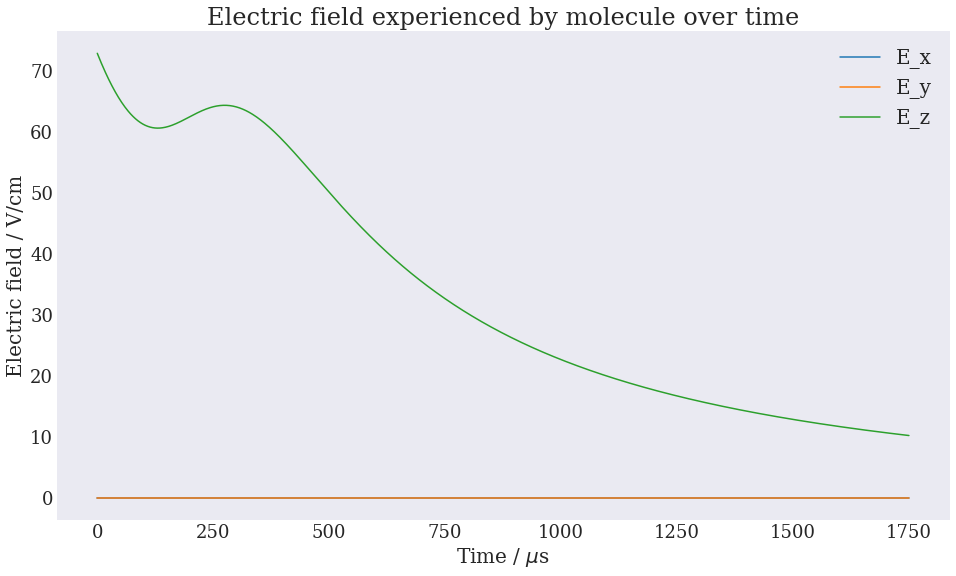

In [49]:
# Plot the electric field as a check:
electric_field.plot(trajectory)

## Define magnetic field
Define the magnetic field. Using a constant field, either a nominal small field (so mF states become non-degenerate eigenstates of the Hamiltonian) or something resembilng Earth's magnetic field.

In [50]:
# B = np.array((0,0,1e-3))
B = np.array((0.2,0.45,0.1))
magnetic_field = MagneticField(lambda R: np.repeat(B.reshape(3,1),R.shape[1], axis = 1))

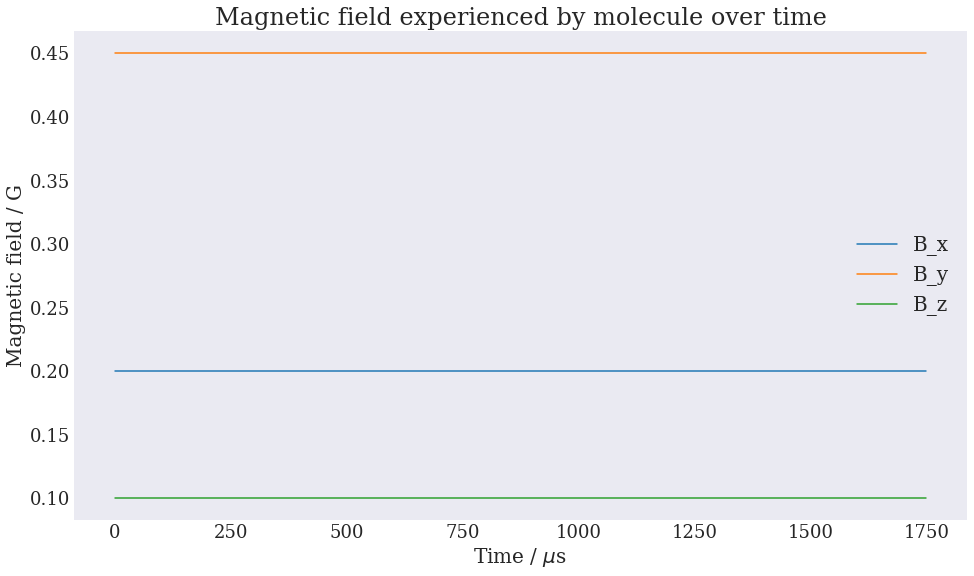

In [51]:
magnetic_field.plot(trajectory)

## Initial states
Define approximate initial states here.

In [52]:
#Define some useful approximate states
J2_singlet = 1/np.sqrt(2) * (1*UncoupledBasisState(J = 2, mJ = 0, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = -1/2, P = +1, Omega = 0, electronic_state='X')
                                       -1* UncoupledBasisState(J = 2, mJ = 0, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = 1/2, P = +1, Omega = 0, electronic_state='X'))

J2_triplet_0 = 1/np.sqrt(2) * (1*UncoupledBasisState(J = 2, mJ = 0, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = -1/2, P = +1, Omega = 0, electronic_state='X')
                            +1* UncoupledBasisState(J = 2, mJ = 0, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = 1/2, P = +1, Omega = 0, electronic_state='X'))

J2_triplet_p = 1*UncoupledBasisState(J = 2, mJ = 0, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = 1/2, P = +1, Omega = 0, electronic_state='X')

J2_triplet_m = 1*UncoupledBasisState(J = 2, mJ = 0, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = -1/2, P = +1, Omega = 0, electronic_state='X')

initial_states_approx = [J2_singlet, J2_triplet_m, J2_triplet_0, J2_triplet_p]

## Define slowly varying Hamiltonian
Define a Hamiltonian object that represents the slowly varying part of the Hamiltonian (i.e. everything except the microwaves). Using J = 0-3 here since we're interested in the time-evolution of J = 2 states; J = 1 and 3 are absolutely required since the electric field couples J = 2 to these, J = 0 is not strictly necessary. Since the Stark energies are << the rotational energies, we mostly just need the J of interest $\pm 1$.

In [53]:
Js = [0,1,2,3,4]
hamiltonian = SlowHamiltonian(Js)

## Time-evolution
Next define a Simulator and use it to numerically integrate the Schroedinger equation to see how the states evolve as the electric field is ramped down. 

In [54]:
simulator = Simulator(trajectory, electric_field, magnetic_field, initial_states_approx, hamiltonian)

In [55]:
result = simulator.run()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:21<00:00, 458.42it/s]


## Plot results

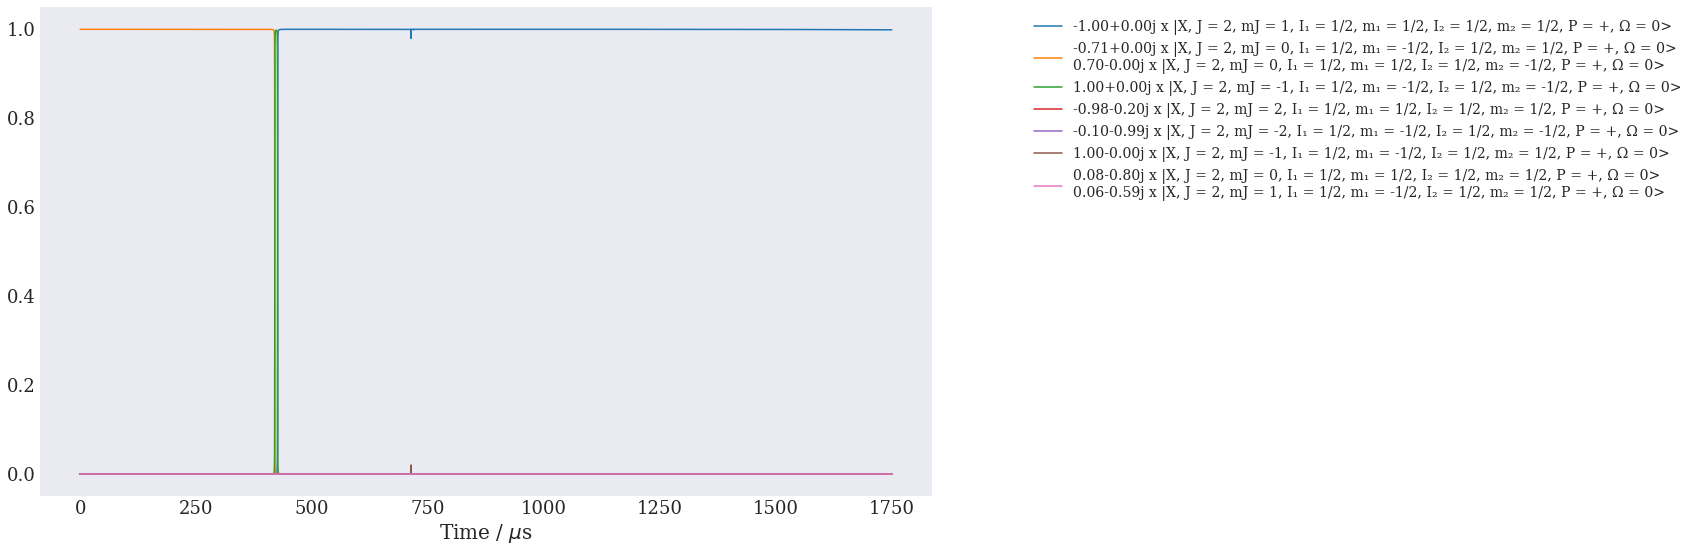

In [56]:
initial_state = result.initial_states[0]
large_prob_states = result.find_large_prob_states(initial_state, N = 7)
fig, ax = plt.subplots()
result.plot_state_probabilities(large_prob_states, initial_state, ax = ax)
ax.legend(fontsize = 14, bbox_to_anchor = (1.1,1))

## Convert final state vectors to coupled basis

In [57]:
QN = result.hamiltonian.QN

# Starting in singlet
final_state_vec_singlet = result.psis[-1,0,:]
final_state_singlet = (vector_to_state(final_state_vec_singlet, QN).remove_small_components().transform_to_coupled()
                       .order_by_amp())
print("|J = 2, mJ = 0, S = 0 > ->")
final_state_singlet.make_real().print_state()

#Starting in triplet_m
final_state_vec_triplet_m = result.psis[-1,1,:]
final_state_triplet_m = (vector_to_state(final_state_vec_triplet_m, QN).remove_small_components().transform_to_coupled()
                         .order_by_amp())
print("\n|J = 2, mJ = 0, S = 1, mS = -1 >  ->")
final_state_triplet_m.make_real().print_state()

#Starting in triplet_0
final_state_vec_triplet_0 = result.psis[-1,2,:]
final_state_triplet_0 = (vector_to_state(final_state_vec_triplet_0, QN).remove_small_components().transform_to_coupled()
                         .order_by_amp())
print("\n|J = 2, mJ = 0, S = 1, mS = 0 >  ->")
final_state_triplet_0.make_real().print_state()

#Starting in triplet_p
final_state_vec_triplet_p = result.psis[-1,3,:]
final_state_triplet_p = (vector_to_state(final_state_vec_triplet_p, QN).remove_small_components().transform_to_coupled()
                         .order_by_amp())
print("\n|J = 2, mJ = 0, S = 1, mS = 1 >  ->")
final_state_triplet_p.make_real().print_state()

|J = 2, mJ = 0, S = 0 > ->
-0.9941-0.0000j x |X, J = 2, F₁ = 5/2, F = 2, mF = 0, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>

|J = 2, mJ = 0, S = 1, mS = -1 >  ->
+0.4026-0.4281j x |X, J = 2, F₁ = 5/2, F = 3, mF = -1, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>
-0.5215-0.0754j x |X, J = 2, F₁ = 5/2, F = 3, mF = -2, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>
+0.5160-0.0060j x |X, J = 2, F₁ = 5/2, F = 3, mF = 1, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>
-0.0781-0.2211j x |X, J = 2, F₁ = 5/2, F = 3, mF = 0, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>
-0.0697+0.1840j x |X, J = 2, F₁ = 5/2, F = 3, mF = 2, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>
+0.0548+0.1134j x |X, J = 2, F₁ = 5/2, F = 3, mF = -3, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>

|J = 2, mJ = 0, S = 1, mS = 0 >  ->
+0.6890-0.0000j x |X, J = 2, F₁ = 5/2, F = 3, mF = 0, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>
-0.2338-0.4729j x |X, J = 2, F₁ = 5/2, F = 3, mF = -1, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>
-0.1711+0.4022j x |X, J = 2, F₁ = 5/2, F = 3, mF = 1, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>
-0.1085+0.1568